In [2]:
import numpy as np
import os
import scipy.io
from sklearn.metrics import classification_report,confusion_matrix

'''
variable list:
    d = dimension of the data
    z/z' = number of classes
    a = number of attributes
    m = number of samples

matrices List:
    s/s' = signature matrix [0,1] dimensions = axz
    X = samples dimensions = dxm
    Y = ground truth [-1,1] dimensions = mxz 
    V = weight matrix dimension = dxa
    V+ = weight matrix dimension = axd, matrix to generate samples from attributes
'''

#Function to run the generation, training, and testing of data
def run(d=10,z=20,zPrime=10,a=100,n=50,targetDist = 'equal'):
    m = n * z
    mPrime = n * zPrime

    '''
    This is an attempt to follow the procedure outlined in the paper to reproduce
    the synthetic data
    '''

    #generate signatures for training(s) and test(sPrime) class signatures
    s = np.random.binomial(size=(a,z),n=1,p=0.5)
    sPrime = np.random.binomial(size=(a,zPrime),n=1,p=0.5)
    #Create a ground truth, varying target distribution based on input
    vPlus = np.random.normal(0,1,(a,d))
    if targetDist == 'beta':
        vPlusPrime = np.random.beta(2,5,(a,d))
    elif targetDist =='normal':
        vPlusPrime = np.random.normal(0.5,2,(a,d))
    else:
        vPlusPrime = vPlus
        
    
    #Each row is now a sample of d attributes
    y = np.eye(z)
    y[y==0] = -1
    y = np.tile(y,(n,1))

    #create a zxd matrix (row is a class, col are dimension)
    x = np.zeros((0,d))
    xPrime = np.zeros((0,d))


    #create label vectors
    testLabels = []
    for i in range(zPrime):
        testLabels.append(i)
    testLabels = np.tile(testLabels,(n,1))
    testLabels = testLabels.flatten()

    #create samples
    for i in range(n):
        #create noise
        noise = np.random.normal(0,0.1,(a,z))
        noisySig = np.add(s,noise)
        #now for the target
        noise = np.random.normal(0,0.1,(a,zPrime))
        noisySigPrime = np.add(sPrime,noise)
        #create the data
        x = np.vstack((x,np.matmul(noisySig.T,vPlus)))
        xPrime = np.vstack((xPrime,np.matmul(noisySigPrime.T,vPlusPrime)))

    #Need to make it the proper dxm, after loop it is mxd
    x = x.transpose()
    xPrime = xPrime.transpose()


    '''
    I want to shuffle the data so that the labels are no longer in a 
    repeating pattern.
    '''
    #create indexes to shuffle
    trainIndex = np.random.permutation(m)
    testIndex = np.random.permutation(mPrime)
    #shuffle columns in samples
    x = x[:,trainIndex]
    xPrime = xPrime[:,testIndex]
    #shuffle labels
    y = y[trainIndex]
    testLabels = testLabels[testIndex]
    


    #This is the function given to find the best Hyperparameters
    #alph1 corresponds to gamma, and gamm1 with lambda in the papers closed form
    accu = 0.0
    alph1 = 4
    gamm1 = 1
    for alpha in range(-6, 6):
        for gamma in range(-6,6):
            #One line solution
            part_1_test = np.linalg.pinv(np.matmul(x, x.T) + (10**alpha)*np.eye(x.shape[0]))
            part_0_test = np.matmul(np.matmul(x,y),s.transpose())
            part_2_test = np.linalg.pinv(np.matmul(s, s.transpose()) + (10**gamma)*np.eye(a))

            V = np.matmul(np.matmul(part_1_test,part_0_test),part_2_test)
            #print(V)
            outputs_1 = np.matmul(np.matmul(xPrime.transpose(),V),sPrime)
            #print(outputs_1[0])
            #print([np.argmax(output) for output in outputs_1])
            preds_1 = np.array([np.argmax(output) for output in outputs_1])
            #predictions
            
            cm = confusion_matrix(testLabels, preds_1)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            avg = sum(cm.diagonal())/mPrime
            #print("The top 1% accuracy is:", avg*100)

            if avg > accu:
                accu = avg
                alph1 = alpha
                gamm1 = gamma

    #I am going to use the given closed form solution to get the Matrix v
    part_1_test = np.linalg.pinv(np.matmul(x, x.T) + (10**alph1)*np.eye(x.shape[0]))
    part_0_test = np.matmul(np.matmul(x,y),s.transpose())
    part_2_test = np.linalg.pinv(np.matmul(s, s.transpose()) + (10**gamm1)*np.eye(a))

    V = np.matmul(np.matmul(part_1_test,part_0_test),part_2_test)

    #Test the values
    outputs_1 = np.matmul(np.matmul(xPrime.transpose(),V),sPrime)
    #print(outputs_1[0])
    #print([np.argmax(output) for output in outputs_1])
    preds_1 = np.array([np.argmax(output) for output in outputs_1])
    #print(preds_1.shape)

    cm = confusion_matrix(testLabels, preds_1)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    avg = sum(cm.diagonal())/ zPrime
    #print("The top 1% accuracy is:", avg*100)

    return avg *100



32.800000000000004

In [3]:
#Put in the parameters
d = 10
z = 50
zPrime = 10
a = 50
n = 50 #number of samples of each class

#This to test the models ability to work on different domains
accShared = []
accNormal = []
accBeta = []

for i in range(20):
    accShared.append(run(d,z,zPrime,a,n,'equal'))
    accNormal.append(run(d,z,zPrime,a,n,'normal'))
    accBeta.append(run(d,z,zPrime,a,n,'beta'))

accShared = np.array(accShared)
accNormal = np.array(accNormal)
accBeta = np.array(accBeta)

print("The accuracy of shared distributions:",np.mean(accShared))
print("The accuracy between two normal distributions:",np.mean(accNormal))
print("The accuracy between normal and beta distribution:",np.mean(accBeta))



The accuracy of shared distributions: 53.330000000000005
The accuracy between two normal distributions: 17.380000000000003
The accuracy between normal and beta distribution: 14.180000000000001


In [4]:
'''
Now I am going to test increasing the number of classes keeping the attributes fixed. 
The goal is to see how increasing the number of training classes helps the model properly predict Attributes
'''
d = 10
z = 20
zPrime = 12
a = 65
n = 50 #number of samples of each class

accuracy = []
numClasses = []
stdDev = []

for i in range(20,100,5):
    avg = []
    numClasses.append(i)
    for j in range(20):
        avg.append(run(d,i,zPrime,a,n))
    accuracy.append(np.mean(avg))
    stdDev.append(np.std(avg))

numClasses = np.array(numClasses)


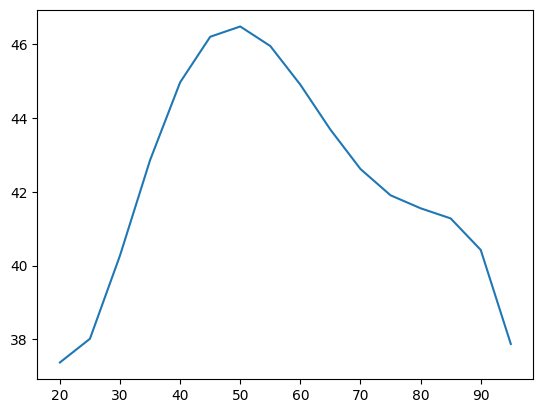

In [5]:
import matplotlib.pyplot as plt

fit = np.polynomial.polynomial.Polynomial.fit(numClasses,accuracy,5)
plot = plt.plot(numClasses,fit(numClasses))
#plt.errorbar(numClasses,fit(numClasses),yerr=stdDev,fmt='o')
#plt.ylim(0,60)
plt.show()

In [6]:
#Play with dimension/attributes

d = 10
z = 20
zPrime = 12
a = 100
n = 50 #number of samples of each class

accuracy = []
numDimensions = []
for i in range(50,150,5):
    avg = []
    numDimensions.append(i)
    for j in range(20):
        avg.append(run(i,z,zPrime,a,n))
    accuracy.append(np.mean(avg))

numDimensions = np.array(numDimensions)

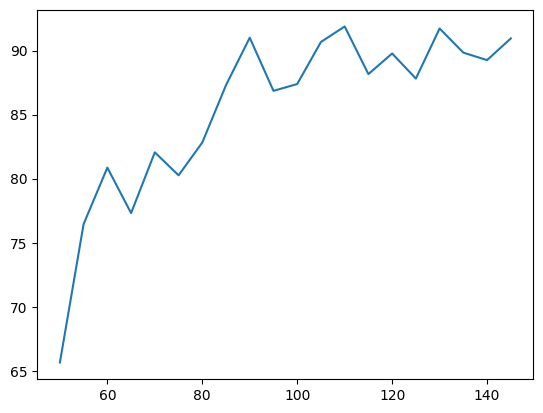

In [7]:

plot = plt.plot(numDimensions,accuracy)
plt.show()